In [1]:
import copy
import google.colab.files
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

TEST_MAX_SCORE = 15
SHOW_LOGS = False

# Upload file to process

In [2]:
uploaded = google.colab.files.upload()
file_name = list(uploaded.keys())[0]

Saving Anonymized results of diagnostic test.xlsx to Anonymized results of diagnostic test (1).xlsx


# Difficulty index

In [3]:
# Input: xlsx file with columns "id" (any type) and fifteen items which are 0 or 1
results_df = pd.read_excel(
    io=file_name,
    header=0,
    names=[
        "id",
        "item1",
        "item2",
        "item3",
        "item4",
        "item5",
        "item6",
        "item7",
        "item8",
        "item9",
        "item10",
        "item11",
        "item12",
        "item13",
        "item14",
        "item15",
    ],
    usecols=[2, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22],
)
results_df = results_df.dropna(subset=["id"])

In [4]:
# item_columns = ["item1", "item2", ...]
item_columns = list(
  filter(
      lambda column_name: "item" in column_name, list(results_df.columns)
  )
)
total_answer_per_item = {}
correct_answer_per_item = {}
for item in item_columns:
  wrong_answer_in_item = results_df.loc[results_df[item] == 0, item].count()

  correct_answer_in_item = results_df.loc[results_df[item] == 1, item].count()
  correct_answer_per_item[item] = correct_answer_in_item

  total_answer_per_item[item] = wrong_answer_in_item + correct_answer_in_item

if SHOW_LOGS:
  print("A, all items", correct_answer_per_item)
  print("N, all items", total_answer_per_item)

p = {}
for item in item_columns:
  A = correct_answer_per_item[item]
  N = total_answer_per_item[item]
  
  p_i = [round(A / N, 2)]
  p[item] = p_i

  if SHOW_LOGS:
    print(f"{item} -> \t", "A_i:", A, "\tN_i:", N, "\tp_i:", p_i[0])

difficulty_df = pd.DataFrame.from_dict(p)

# Discrimination index

In [5]:
# Input: xlsx file with columns "id" (any type), "total_points", and fifteen items which are 0 or 1
results_df = pd.read_excel(
    io=file_name,
    header=0,
    names=[
        "id",
        "total_points",
        "item1",
        "item2",
        "item3",
        "item4",
        "item5",
        "item6",
        "item7",
        "item8",
        "item9",
        "item10",
        "item11",
        "item12",
        "item13",
        "item14",
        "item15",
    ],
    usecols=[2, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22],
)
results_df_original = copy.deepcopy(results_df)
results_df = results_df.dropna(subset=["id"])

In [6]:
sorted_results_df = results_df.sort_values(by=['total_points'], ascending=False)
twenty_seven_percentage = round(results_df.shape[0] * 0.27)
twenty_seven_percentage_upper_group_df = sorted_results_df[:twenty_seven_percentage]
twenty_seven_percentage_lower_group_df = sorted_results_df[-twenty_seven_percentage:]

item_columns = list(
  filter(
      lambda column_name: "item" in column_name, list(results_df.columns)
  )
)

n_people_largest_group_per_item = {}
correct_answer_upper_group_per_item = {}
correct_answer_lower_group_per_item = {}
for item in item_columns:
  correct_answer_upper_group_in_item = twenty_seven_percentage_upper_group_df.loc[twenty_seven_percentage_upper_group_df[item] == 1, item].count()
  correct_answer_lower_group_in_item = twenty_seven_percentage_lower_group_df.loc[twenty_seven_percentage_lower_group_df[item] == 1, item].count()
  
  correct_answer_upper_group_per_item[item] = correct_answer_upper_group_in_item
  correct_answer_lower_group_per_item[item] = correct_answer_lower_group_in_item

  n_people_largest_group_per_item[item] = (
      correct_answer_upper_group_in_item
      if correct_answer_upper_group_in_item >= correct_answer_lower_group_in_item
      else correct_answer_lower_group_in_item
  )


if SHOW_LOGS:
  print("GA, all items", correct_answer_upper_group_per_item)
  print("GB, all items", correct_answer_lower_group_per_item)
  print("N, all items", n_people_largest_group_per_item)

D = {}
for item in item_columns:
  GA = correct_answer_upper_group_per_item[item]
  GB = correct_answer_lower_group_per_item[item]
  N = n_people_largest_group_per_item[item]

  D_i = [round((GA - GB) / N, 2)]
  D[item] = D_i

  if SHOW_LOGS:
    print(f"{item} -> \t", "GA_i:", GA, "\t\tGB_i:", GB, "\t\tN_i:", N, "\t\tD_i:", D_i[0])

if SHOW_LOGS:
  print("D, all items:", D)

discrimination_df = pd.DataFrame.from_dict(D)

# Cronbach $\alpha$

In [7]:
# items is a dataframe with items in columns
def cronbach_alpha(items):

    # Based on Cronbach (1951), "Coefficient alpha and the internal structure of tests"

    items_count = items.shape[1]
    item_score_variance_sum = float(items.var(axis=0, ddof=1).sum()) # sum of variance of item i
    test_scores_variance = float(items.sum(axis=1).var(ddof=1)) # variance of the sum of total points of students
    K = items_count

    alpha = (K / (K - 1)) * (1 - (item_score_variance_sum / test_scores_variance))
    
    return alpha

# Input: xlsx file with columns "id" (any type), and fifteen items which are 0 or 1
results_df = pd.read_excel(
    io=file_name,
    header=0,
    names=[
        "id",
        "item1",
        "item2",
        "item3",
        "item4",
        "item5",
        "item6",
        "item7",
        "item8",
        "item9",
        "item10",
        "item11",
        "item12",
        "item13",
        "item14",
        "item15",
    ],
    usecols=[2, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22],
)
results_df_original = copy.deepcopy(results_df)
# drop rows with null ID
results_df = results_df.dropna(subset=["id"])
results_df.drop(
    ["id"], axis=1, inplace=True,
)
# Update "-"" to None
results_df = results_df.replace("-", None)

cronbach_alpha_result = cronbach_alpha(results_df)

if SHOW_LOGS:
  print("cronbach_alpha: ", cronbach_alpha_result)

cronbach_alpha_df = pd.DataFrame.from_dict({"Cronbach alpha": [cronbach_alpha_result]})
cronbach_alpha_df

,Cronbach alpha
0,0.674006


# Measures of central tendency

In [8]:
# Input: xlsx file with columns "id" (any type), "total_points", and fifteen items which are 0 or 1
results_df = pd.read_excel(
    io=file_name,
    header=0,
    names=[
        "id",
        "total_points",
        "item1",
        "item2",
        "item3",
        "item4",
        "item5",
        "item6",
        "item7",
        "item8",
        "item9",
        "item10",
        "item11",
        "item12",
        "item13",
        "item14",
        "item15",
    ],
    usecols=[2, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22],
)
results_df_original = copy.deepcopy(results_df)
results_df = results_df.dropna(subset=["id"])

results_df = results_df.replace("-", 0)

In [9]:
pd.set_option('display.max_rows', 600)
results_df

,id,total_points,item1,item2,item3,item4,item5,item6,item7,item8,item9,item10,item11,item12,item13,item14,item15
0,0,13,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1
1,1,5,0,0,1,1,0,0,1,0,1,0,0,1,0,0,0
2,2,6,1,0,1,0,0,0,0,0,1,0,0,0,1,1,1
3,3,14,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1
4,4,11,1,1,1,1,0,1,1,0,1,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954,954,12,1,1,1,1,0,1,1,1,1,0,0,1,1,1,1
955,955,12,1,1,0,0,1,1,0,1,1,1,1,1,1,1,1
956,956,5,1,0,1,1,0,0,0,0,1,0,0,0,0,1,0
957,957,13,1,1,1,1,1,0,1,1,1,1,1,1,0,1,1


## Statistics by item for a specific site and race (file to be processed has only this data)

In [10]:
# Obtain central tendency values for score data

central_tendency_df = results_df.drop(results_df.index)
central_tendency_df.loc['mean'] = results_df.mean(axis = 0, numeric_only=True)
central_tendency_df.loc['std'] = results_df.std(axis = 0, numeric_only=True)
central_tendency_df.loc['median'] = results_df.median(axis = 0, numeric_only=True)
central_tendency_df.loc['min'] = results_df.min(axis = 0, numeric_only=True)
central_tendency_df.loc['max'] = results_df.max(axis = 0, numeric_only=True)
central_tendency_df.drop(
    ["id"], axis=1, inplace=True,
)

# Round values
for column in results_df.columns:
  # Avoid processing column which are not an item score
  try:
    central_tendency_df[column] = central_tendency_df[column].map(
        lambda score: round(score, 2)
    )
  except KeyError:
    pass

central_tendency_df = central_tendency_df.rename(
    columns={
        "total_points": "Mark/15",
        "item1": "Item 1",
        "item2": "Item 2",
        "item3": "Item 3",
        "item4": "Item 4",
        "item5": "Item 5",
        "item6": "Item 6",
        "item7": "Item 7",
        "item8": "Item 8",
        "item9": "Item 9",
        "item10": "Item 10",
        "item11": "Item 11",
        "item12": "Item 12",
        "item13": "Item 13",
        "item14": "Item 14",
        "item15": "Item 15",
    }
)

central_tendency_df

,Mark/15,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6,Item 7,Item 8,Item 9,Item 10,Item 11,Item 12,Item 13,Item 14,Item 15
mean,10.95,0.93,0.73,0.81,0.89,0.60,0.66,0.56,0.61,0.9,0.48,0.71,0.65,0.57,0.94,0.91
std,2.73,0.26,0.44,0.39,0.31,0.49,0.47,0.50,0.49,0.3,0.50,0.45,0.48,0.50,0.24,0.29
median,11.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,0.00,1.00,1.00,1.00,1.00,1.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
max,15.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00


## Statistics by dimension for a specific site and race (file to be processed has only the data for a site and race, and includes the scores in each item).

### Mapping dimensions

In [11]:
# Manual mapping of dimensions
dimensions_item_map = {
    "Abstraction [%]": [
        "item2",
        "item3",
        "item4",
        "item5",
        "item6",
        "item12",
        "item13",
        "item14",
        "item15"
    ],
    "Pattern rec. [%]": [
        "item3",
        "item4",
        "item5",
        "item9",
        "item10",
        "item11"
    ],
    "Algorithms [%]": [
        "item1",
        "item6",
        "item7",
        "item8",
        "item12",
        "item13",
        "item14",
        "item15"
    ],
}

dimensions_item_map_names = ["Abstraction", "Pattern recognition",  "Algorithms"]

### Obtain score by dimension, in percentage

In [12]:
result_df_by_dim = copy.deepcopy(results_df)
global items_columns

# Funtion to group scores by dimension
def parse_row_item_points_to_dim(row):

  if SHOW_LOGS: print("id:", row["id"])

  for column in items_columns:

    if SHOW_LOGS: print("Column:", column)
    
    for dim, items_in_dim_list in dimensions_item_map.items():

      if SHOW_LOGS: print("Dim:", dim)

      if column in items_in_dim_list:
        row[dim] += row[column]

    if SHOW_LOGS: print("\n")

  return row

items_columns = []
for column in result_df_by_dim.columns:
  # Avoid processing column which are not an item score
  if not re.search("item(?:\d+)", column):
    continue
  items_columns.append(column)

for dim in dimensions_item_map.keys():
  result_df_by_dim[dim] = 0

result_df_by_dim = result_df_by_dim.apply(parse_row_item_points_to_dim, axis=1)

# Delete normal score columns (columns with score 0 or 1)
result_df_by_dim.drop(
    items_columns, axis=1, inplace=True,
)

# Standardize data by dimension, making columns relative to total quantity of
# element in each dimension and give final value in percentage
for dim in dimensions_item_map.keys():
  result_df_by_dim[dim] = result_df_by_dim[dim].map(
      lambda dim_score: (dim_score / len(dimensions_item_map[dim])) * 100
  )
result_df_by_dim["total_points"] = result_df_by_dim["total_points"].map(
      lambda total_score: (total_score / TEST_MAX_SCORE) * 100
  )

# Show processed data with values in percentage
result_df_by_dim

,id,total_points,Abstraction [%],Pattern rec. [%],Algorithms [%]
0,0,86.666667,88.888889,83.333333,100.0
1,1,33.333333,33.333333,50.000000,25.0
2,2,40.000000,44.444444,33.333333,50.0
3,3,93.333333,88.888889,100.000000,87.5
4,4,73.333333,88.888889,50.000000,87.5
...,...,...,...,...,...
954,954,80.000000,88.888889,50.000000,100.0
955,955,80.000000,77.777778,66.666667,87.5
956,956,33.333333,33.333333,50.000000,25.0
957,957,86.666667,77.777778,100.000000,75.0


In [13]:
# Obtain central tendency values for score by dimension data
central_tendency_df_by_dim = result_df_by_dim.drop(results_df.index)
central_tendency_df_by_dim.loc['mean'] = result_df_by_dim.mean(axis = 0, numeric_only=True)
central_tendency_df_by_dim.loc['std'] = result_df_by_dim.std(axis = 0, numeric_only=True)
central_tendency_df_by_dim.loc['median'] = result_df_by_dim.median(axis = 0, numeric_only=True)
central_tendency_df_by_dim.loc['min'] = result_df_by_dim.min(axis = 0, numeric_only=True)
central_tendency_df_by_dim.loc['max'] = result_df_by_dim.max(axis = 0, numeric_only=True)
central_tendency_df_by_dim.drop(
    ["id"], axis=1, inplace=True,
)

# Round values
for dim in dimensions_item_map.keys():
  central_tendency_df_by_dim[dim] = central_tendency_df_by_dim[dim].map(
      lambda dim_score: round(dim_score, 2)
  )
central_tendency_df_by_dim["total_points"] = central_tendency_df_by_dim["total_points"].map(
    lambda score: round(score, 2)
)
central_tendency_df_by_dim = central_tendency_df_by_dim.rename(
    columns={'total_points': 'Mark/15 [%]'}
)

central_tendency_df_by_dim

,Mark/15 [%],Abstraction [%],Pattern rec. [%],Algorithms [%]
mean,73.01,75.11,73.15,72.89
std,18.21,20.53,22.41,20.74
median,73.33,77.78,83.33,75.00
min,6.67,0.00,0.00,0.00
max,100.00,100.00,100.00,100.00


### Plotting data dispersion

Text(0, 0.5, 'Achievement [%]')

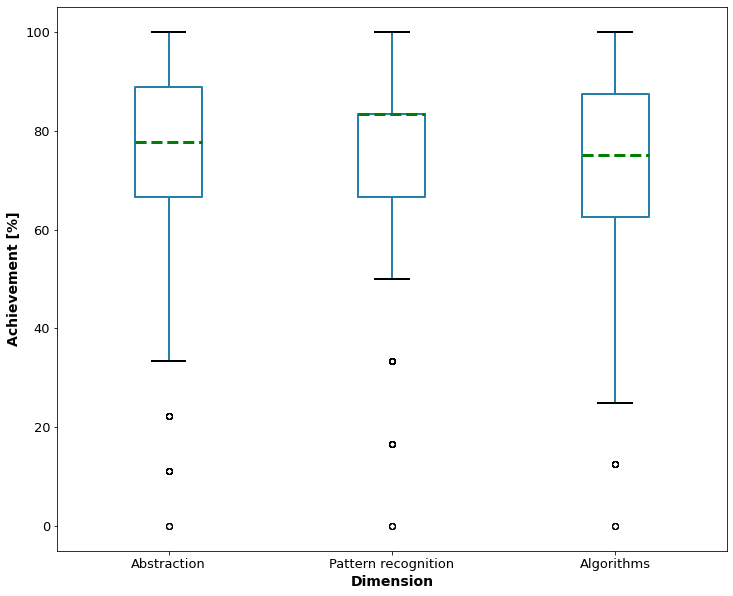

In [14]:
# BLACK GRAPH
np.random.seed(2020)
result_df_by_dim.rename(
    columns={
        "Abstraction [%]": "Abstraction",
        "Pattern rec. [%]": "Pattern recognition",
        "Algorithms [%]": "Algorithms",
    },
    inplace=True
)

boxprops = dict(linestyle='-', linewidth=2, color='#277fab')
medianprops = dict(linestyle='--', linewidth=3, color='g')
capprops = dict(linestyle='-', linewidth=2, color='k')

boxplot = result_df_by_dim.boxplot(
    grid=False, 
    column=dimensions_item_map_names,
    figsize=(12, 10),
    fontsize=13,
    medianprops=medianprops,
    boxprops=boxprops,
    whiskerprops=boxprops,
    capprops=capprops
)
boxplot.set_xlabel('Dimension', fontsize=14, fontdict=dict(weight='bold'))
boxplot.set_ylabel('Achievement [%]', fontsize=14, fontdict=dict(weight='bold'))

Text(0, 0.5, 'Achievement [%]')

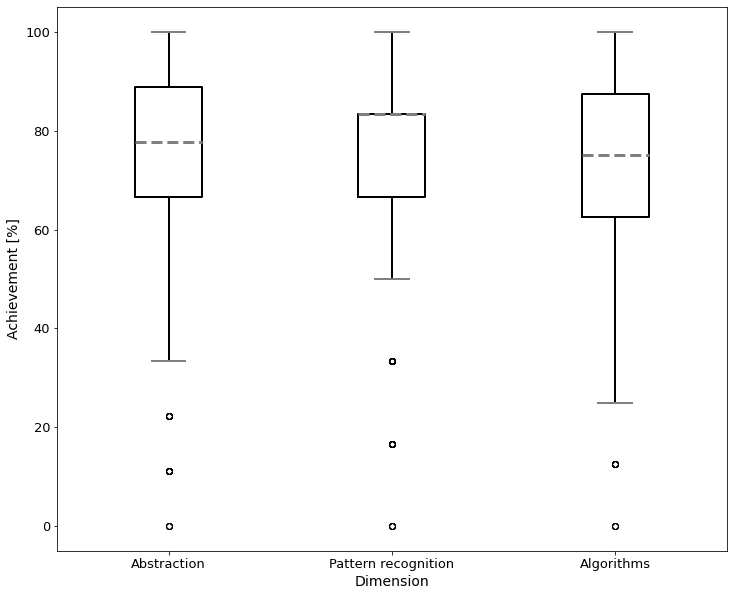

In [15]:
# Grayscale image
np.random.seed(2020)
result_df_by_dim.rename(
    columns={
        "Abstraction [%]": "Abstraction",
        "Pattern rec. [%]": "Pattern rec.",
        "Algorithms [%]": "Algorithms",
    },
    inplace=True
)

boxprops = dict(linestyle='-', linewidth=2, color='k')
medianprops = dict(linestyle='--', linewidth=3, color='gray')
capprops = dict(linestyle='-', linewidth=2, color='gray')
color = dict(boxes='black', whiskers='black', medians='black', caps='#808080')

boxplot_grayscale = result_df_by_dim.boxplot(
    grid=False, 
    column=dimensions_item_map_names,
    figsize=(12, 10),
    fontsize=13,
    medianprops=medianprops,
    boxprops=boxprops,
    whiskerprops=boxprops,
    capprops=capprops,
    color=color
)
boxplot_grayscale.set_xlabel('Dimension', fontsize=14)
boxplot_grayscale.set_ylabel('Achievement [%]', fontsize=14)

### Download boxplot as image

In [16]:
boxplot.figure.savefig(
    "Boxplot percentage of achievement by dimension.jpg",
    format='jpeg',
    dpi=200
)

boxplot_grayscale.figure.savefig(
    "Boxplot percentage of achievement by dimension grayscale.jpg",
    format='jpeg',
    dpi=200
)

# Download processed file

In [22]:
preprocessed_results_df = pd.read_excel(
    io=file_name,
    header=0,
)

with pd.ExcelWriter(f"Processed {file_name}") as writer:  
    preprocessed_results_df.to_excel(writer, sheet_name="Pre-processed results", index=False)
    difficulty_df.to_excel(writer, sheet_name="Difficulty index", index=False)
    discrimination_df.to_excel(writer, sheet_name="Discrimination index", index=False)
    central_tendency_df.to_excel(writer, sheet_name="Measures by item", index=True)
    central_tendency_df_by_dim.to_excel(writer, sheet_name="Measures by dimension", index=True)
    cronbach_alpha_df.to_excel(writer, sheet_name="Cronbach alpha", index=False)

google.colab.files.download(f"Processed {file_name}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
result_df_by_dim.shape

(959, 5)